In [1]:
from sys import path
path.append('..')
path.append('../../src/')

import os
import cv2
import numpy as np
import pickle as pkl
import matplotlib.pyplot as plt
import mlflow
import mlflow.keras
import random as rn
import tensorflow as tf
from os.path import basename, join, exists
from sys import stdout

from keras.models import Model, load_model
from keras.layers import Input, Dense, Dropout, BatchNormalization, Activation, Concatenate
from keras.layers import Conv2D, Conv2DTranspose, MaxPool2D, UpSampling2D, GlobalAvgPool2D
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.utils.data_utils import Sequence
from keras.utils.vis_utils import plot_model

import imgaug as ia
import imgaug.augmenters as iaa

from skmultilearn.model_selection import iterative_train_test_split

from tensorflow.contrib.tensorboard.plugins import projector

from global_config import RANDOM_SEED, IMAGE_SIZE, FOLDER_IMAGES, FOLDER_MRKS
from local_config import FOLDER_MODELS, FILE_AUTOENCODER_SAMPLES, FILE_DATASET
from custom_losses import wing_loss
from custom_metrics import precision, recall, f1, specificity, fbeta
from custom_metrics import negative_predictive_value as npv 
from custom_metrics import matthews_correlation_coefficient as mcc
from custom_metrics import eye_localization_accuracy, eye_localization_fvc
from icao_dataset import ICAODataset
from data_structures import Point
from utils import plot, load

%matplotlib inline

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\tensorflow\python\util\nest.py:823: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  _pywrap_tensorflow.RegisterType("Mapping", _collections.Mapping)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\tensorflow\python\training\checkpointable\data_structures.py:312: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  class _ListWrapper(List, collections.MutableSequence,
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\tensorflow\python\training\checkpointable\util.py:448: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  class _ObjectIdentitySet(collections.MutableSet):
Using Te

In [2]:
PATH_TO_ROOT = '../../'

FOLDER_LOGS = join(PATH_TO_ROOT, 'logs')
FOLDER_MODELS = join(PATH_TO_ROOT, FOLDER_MODELS)
FILE_DATASET = join(PATH_TO_ROOT, FILE_DATASET)
FILE_AUTOENCODER_SAMPLES = join(PATH_TO_ROOT, FILE_AUTOENCODER_SAMPLES)
FILE_BEST_MODEL = join(PATH_TO_ROOT, 'models/unsupervised_supervised/multilearner_2020_07_12-02_22_54.h5')

print(FOLDER_LOGS)
print(FOLDER_MODELS)
print(FILE_DATASET)
print(FILE_AUTOENCODER_SAMPLES)
print(FILE_BEST_MODEL)

../../logs
../../models/unsupervised_supervised/
../../data/cropped_faces_eyes/dataset_dlib.pkl
../../data/unsupervised_supervised_samples.pkl
../../models/unsupervised_supervised/multilearner_2020_07_12-02_22_54.h5


In [3]:
TEST_SIZE = 0.1
MLFLOW_EXPERIMENT_NAME = 'Unsupervised + Supervised'

In [4]:
def timestamp_model_name(prefix='model_', suffix='', format='%Y_%m_%d-%H_%M_%S', ext='.h5'):
    from datetime import datetime
    timestamp = datetime.now().strftime(format)
    return f'{prefix}{timestamp}{suffix}{ext}'


def set_random_seeds():
    os.environ['PYTHONHASHSEED'] = str(RANDOM_SEED)
    rn.seed(RANDOM_SEED)
    np.random.seed(RANDOM_SEED)
    tf.set_random_seed(RANDOM_SEED)

# Data Loading 

In [5]:
if exists(FILE_DATASET):
    print("Dataset found. Loading...")
    dataset = pkl.load(open(FILE_DATASET, "rb"))
else:
    print("Generating dataset...")
    dataset = ICAODataset()
    dataset.load(FOLDER_IMAGES, FOLDER_MRKS, output_size=(160, 160))
    pkl.dump(dataset, open(FILE_DATASET, "wb"))

Dataset found. Loading...


In [6]:
x = np.array(dataset.images)
mrks = np.array(dataset.mrks)
y_reqs = np.array([mrk_file.photo_reqs.values() for mrk_file in mrks])
y_eyes = np.array([mrk_file.right_eye.center().as_list() + mrk_file.left_eye.center().as_list() for mrk_file in mrks])

print(x.shape, x.dtype)
print(y_reqs.shape, y_reqs.dtype)
print(y_eyes.shape, y_eyes.dtype)
print(len(mrks))

(4999, 160, 160, 3) float32
(4999, 23) int32
(4999, 4) float64
4999


In [7]:
y_eyes.min(), y_eyes.max()

(51.5, 104.5)

In [8]:
x /= 255
y_eyes /= x.shape[1]

In [9]:
x.min(), x.max()

(0.0, 1.0)

In [10]:
y_eyes.min(), y_eyes.max()

(0.321875, 0.653125)

#### divide train and test

In [11]:
np.random.seed(RANDOM_SEED)
x_train_idx, y_train_reqs, x_val_idx, y_val_reqs = iterative_train_test_split(
    np.arange(x.shape[0]).reshape(-1, 1),
    y_reqs,
    test_size=TEST_SIZE
)
x_train_idx = x_train_idx.ravel()
x_val_idx = x_val_idx.ravel()

x_train = x[x_train_idx]
x_val = x[x_val_idx]

y_train_eyes = y_eyes[x_train_idx]
y_val_eyes = y_eyes[x_val_idx]

print(x_train.shape, y_train_reqs.shape, y_train_eyes.shape)
print(x_val.shape, y_val_reqs.shape, y_val_eyes.shape)

(4490, 160, 160, 3) (4490, 23) (4490, 4)
(509, 160, 160, 3) (509, 23) (509, 4)


In [12]:
train_mrks = mrks[x_train_idx]
val_mrks = mrks[x_val_idx]

# Model Training 

In [13]:
custom_objects = {
    "precision": precision,
    "recall": recall,
    "f1": f1,
    "specificity": specificity,
    "fbeta": fbeta,
    "negative_predictive_value": npv,
    "matthews_correlation_coefficient": mcc
}

best_model = load_model(FILE_BEST_MODEL, custom_objects=custom_objects)

for layer in best_model.layers:
    layer.trainable = False

Instructions for updating:
Colocations handled automatically by placer.


C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)


Instructions for updating:
Use tf.cast instead.


In [14]:
def dense_layer(idx, prev_input, units, dropout=True, rate=0.5, activation='relu'):
    dense_name = f"dense_{idx}"
    drop_name = f"dropout_{idx}"
    
    if dropout:
        prev_input = Dropout(rate, name=drop_name)(prev_input)
    out = Dense(units, activation=activation, name=dense_name)(prev_input)
    return out

In [15]:
mlflow.set_experiment(MLFLOW_EXPERIMENT_NAME)
mlflow.log_param("test_size", TEST_SIZE)
mlflow.log_param("seed", RANDOM_SEED)
mlflow.keras.autolog()

set_random_seeds()
N_EYES = y_train_eyes.shape[1]

avg_pool = best_model.get_layer("global_average_pooling2d_1").output

dense_3 = dense_layer(3, avg_pool, 64)
dense_4 = dense_layer(4, dense_3, 64)
regress = Dense(units=N_EYES, activation='sigmoid', name='output_eyes')(dense_4)

model = Model(
    inputs=best_model.inputs,
    outputs=[
        best_model.get_layer("decoded").output,
        best_model.get_layer("outputs").output,
        regress
    ],
)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 160, 160, 3)  0                                            
__________________________________________________________________________________________________
conv_1 (Conv2D)                 (None, 160, 160, 32) 896         input[0][0]                      
__________________________________________________________________________________________________
bn_1 (BatchNormalization)       (None, 160, 160, 32) 128         conv_1[0][0]                     
__________________________________________________________________________________________________
relu_1 (Activation)             (None, 160, 160, 32) 0           bn_1[0][0]                       
____________________________________________________________________________________________

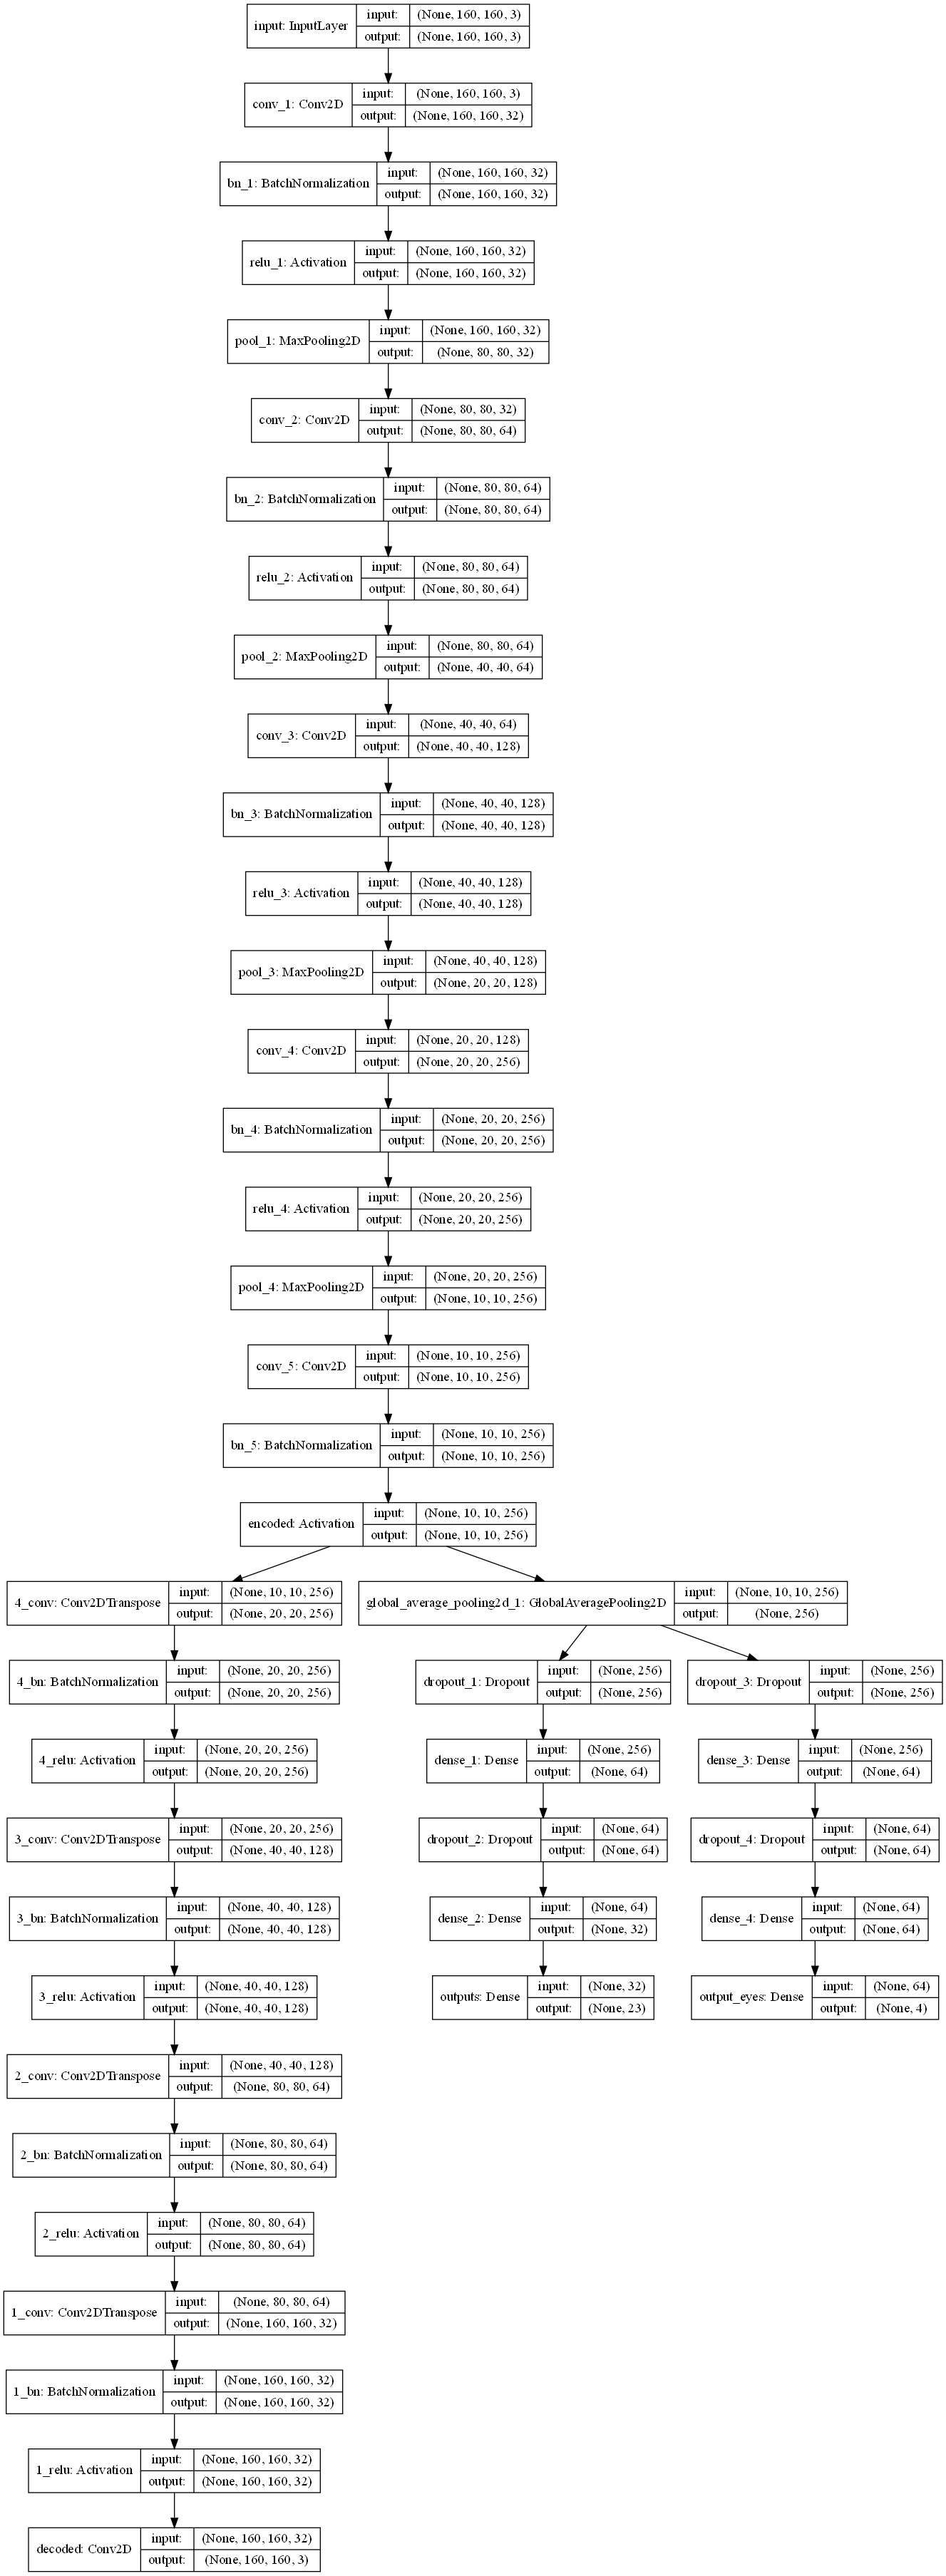

In [16]:
plot_model(model, show_shapes=True)

Train on 4490 samples, validate on 509 samples
Epoch 1/500
4490/4490 [==============================] - 24s 5ms/step - loss: 0.4979 - decoded_loss: 0.0036 - outputs_loss: 0.1679 - output_eyes_loss: 0.4974 - outputs_accuracy: 0.9317 - outputs_precision: 0.9467 - outputs_recall: 0.9717 - outputs_f1: 0.9590 - outputs_fbeta: 0.9650 - outputs_specificity: 0.7475 - outputs_negative_predictive_value: 0.8507 - outputs_matthews_correlation_coefficient: 0.7571 - output_eyes_mae: 0.0252 - output_eyes_mse: 0.0011 - output_eyes_eye_localization_accuracy: 0.0398 - val_loss: 0.2799 - val_decoded_loss: 0.0043 - val_outputs_loss: 0.1583 - val_output_eyes_loss: 0.2797 - val_outputs_accuracy: 0.9415 - val_outputs_precision: 0.9474 - val_outputs_recall: 0.9815 - val_outputs_f1: 0.9639 - val_outputs_fbeta: 0.9737 - val_outputs_specificity: 0.7720 - val_outputs_negative_predictive_value: 0.9027 - val_outputs_matthews_correlation_coefficient: 0.7997 - val_output_eyes_mae: 0.0141 - val_output_eyes_mse: 3.1900

4490/4490 [==============================] - 20s 4ms/step - loss: 0.2339 - decoded_loss: 0.0036 - outputs_loss: 0.1653 - output_eyes_loss: 0.2340 - outputs_accuracy: 0.9323 - outputs_precision: 0.9465 - outputs_recall: 0.9726 - outputs_f1: 0.9594 - outputs_fbeta: 0.9658 - outputs_specificity: 0.7463 - outputs_negative_predictive_value: 0.8545 - outputs_matthews_correlation_coefficient: 0.7586 - output_eyes_mae: 0.0118 - output_eyes_mse: 2.6193e-04 - output_eyes_eye_localization_accuracy: 0.3423 - val_loss: 0.2026 - val_decoded_loss: 0.0043 - val_outputs_loss: 0.1583 - val_output_eyes_loss: 0.2025 - val_outputs_accuracy: 0.9415 - val_outputs_precision: 0.9474 - val_outputs_recall: 0.9815 - val_outputs_f1: 0.9639 - val_outputs_fbeta: 0.9737 - val_outputs_specificity: 0.7720 - val_outputs_negative_predictive_value: 0.9027 - val_outputs_matthews_correlation_coefficient: 0.7997 - val_output_eyes_mae: 0.0102 - val_output_eyes_mse: 1.7637e-04 - val_output_eyes_eye_localization_accuracy: 0.408

4490/4490 [==============================] - 20s 4ms/step - loss: 0.2267 - decoded_loss: 0.0035 - outputs_loss: 0.1684 - output_eyes_loss: 0.2266 - outputs_accuracy: 0.9314 - outputs_precision: 0.9460 - outputs_recall: 0.9721 - outputs_f1: 0.9588 - outputs_fbeta: 0.9653 - outputs_specificity: 0.7432 - outputs_negative_predictive_value: 0.8513 - outputs_matthews_correlation_coefficient: 0.7550 - output_eyes_mae: 0.0114 - output_eyes_mse: 2.4865e-04 - output_eyes_eye_localization_accuracy: 0.3710 - val_loss: 0.2030 - val_decoded_loss: 0.0043 - val_outputs_loss: 0.1583 - val_output_eyes_loss: 0.2030 - val_outputs_accuracy: 0.9415 - val_outputs_precision: 0.9474 - val_outputs_recall: 0.9815 - val_outputs_f1: 0.9639 - val_outputs_fbeta: 0.9737 - val_outputs_specificity: 0.7720 - val_outputs_negative_predictive_value: 0.9027 - val_outputs_matthews_correlation_coefficient: 0.7997 - val_output_eyes_mae: 0.0102 - val_output_eyes_mse: 1.7589e-04 - val_output_eyes_eye_localization_accuracy: 0.395

4490/4490 [==============================] - 20s 4ms/step - loss: 0.2216 - decoded_loss: 0.0035 - outputs_loss: 0.1672 - output_eyes_loss: 0.2214 - outputs_accuracy: 0.9323 - outputs_precision: 0.9464 - outputs_recall: 0.9728 - outputs_f1: 0.9594 - outputs_fbeta: 0.9660 - outputs_specificity: 0.7454 - outputs_negative_predictive_value: 0.8546 - outputs_matthews_correlation_coefficient: 0.7582 - output_eyes_mae: 0.0111 - output_eyes_mse: 2.4214e-04 - output_eyes_eye_localization_accuracy: 0.3929 - val_loss: 0.1988 - val_decoded_loss: 0.0043 - val_outputs_loss: 0.1583 - val_output_eyes_loss: 0.1988 - val_outputs_accuracy: 0.9415 - val_outputs_precision: 0.9474 - val_outputs_recall: 0.9815 - val_outputs_f1: 0.9639 - val_outputs_fbeta: 0.9737 - val_outputs_specificity: 0.7720 - val_outputs_negative_predictive_value: 0.9027 - val_outputs_matthews_correlation_coefficient: 0.7997 - val_output_eyes_mae: 0.0100 - val_output_eyes_mse: 1.6929e-04 - val_output_eyes_eye_localization_accuracy: 0.441

4490/4490 [==============================] - 20s 4ms/step - loss: 0.2195 - decoded_loss: 0.0036 - outputs_loss: 0.1695 - output_eyes_loss: 0.2194 - outputs_accuracy: 0.9311 - outputs_precision: 0.9459 - outputs_recall: 0.9717 - outputs_f1: 0.9586 - outputs_fbeta: 0.9648 - outputs_specificity: 0.7444 - outputs_negative_predictive_value: 0.8496 - outputs_matthews_correlation_coefficient: 0.7545 - output_eyes_mae: 0.0110 - output_eyes_mse: 2.3507e-04 - output_eyes_eye_localization_accuracy: 0.3809 - val_loss: 0.2020 - val_decoded_loss: 0.0043 - val_outputs_loss: 0.1583 - val_output_eyes_loss: 0.2020 - val_outputs_accuracy: 0.9415 - val_outputs_precision: 0.9474 - val_outputs_recall: 0.9815 - val_outputs_f1: 0.9639 - val_outputs_fbeta: 0.9737 - val_outputs_specificity: 0.7720 - val_outputs_negative_predictive_value: 0.9027 - val_outputs_matthews_correlation_coefficient: 0.7997 - val_output_eyes_mae: 0.0101 - val_output_eyes_mse: 1.7421e-04 - val_output_eyes_eye_localization_accuracy: 0.385

4490/4490 [==============================] - 20s 4ms/step - loss: 0.2168 - decoded_loss: 0.0035 - outputs_loss: 0.1671 - output_eyes_loss: 0.2165 - outputs_accuracy: 0.9321 - outputs_precision: 0.9467 - outputs_recall: 0.9721 - outputs_f1: 0.9592 - outputs_fbeta: 0.9655 - outputs_specificity: 0.7472 - outputs_negative_predictive_value: 0.8519 - outputs_matthews_correlation_coefficient: 0.7576 - output_eyes_mae: 0.0109 - output_eyes_mse: 2.3239e-04 - output_eyes_eye_localization_accuracy: 0.3921 - val_loss: 0.2061 - val_decoded_loss: 0.0043 - val_outputs_loss: 0.1583 - val_output_eyes_loss: 0.2060 - val_outputs_accuracy: 0.9415 - val_outputs_precision: 0.9474 - val_outputs_recall: 0.9815 - val_outputs_f1: 0.9639 - val_outputs_fbeta: 0.9737 - val_outputs_specificity: 0.7720 - val_outputs_negative_predictive_value: 0.9027 - val_outputs_matthews_correlation_coefficient: 0.7997 - val_output_eyes_mae: 0.0103 - val_output_eyes_mse: 1.8016e-04 - val_output_eyes_eye_localization_accuracy: 0.373

4490/4490 [==============================] - 20s 4ms/step - loss: 0.2169 - decoded_loss: 0.0036 - outputs_loss: 0.1678 - output_eyes_loss: 0.2172 - outputs_accuracy: 0.9318 - outputs_precision: 0.9464 - outputs_recall: 0.9723 - outputs_f1: 0.9591 - outputs_fbeta: 0.9655 - outputs_specificity: 0.7449 - outputs_negative_predictive_value: 0.8509 - outputs_matthews_correlation_coefficient: 0.7559 - output_eyes_mae: 0.0109 - output_eyes_mse: 2.3361e-04 - output_eyes_eye_localization_accuracy: 0.4031 - val_loss: 0.1963 - val_decoded_loss: 0.0043 - val_outputs_loss: 0.1583 - val_output_eyes_loss: 0.1963 - val_outputs_accuracy: 0.9415 - val_outputs_precision: 0.9474 - val_outputs_recall: 0.9815 - val_outputs_f1: 0.9639 - val_outputs_fbeta: 0.9737 - val_outputs_specificity: 0.7720 - val_outputs_negative_predictive_value: 0.9027 - val_outputs_matthews_correlation_coefficient: 0.7997 - val_output_eyes_mae: 0.0099 - val_output_eyes_mse: 1.6440e-04 - val_output_eyes_eye_localization_accuracy: 0.428

4490/4490 [==============================] - 20s 4ms/step - loss: 0.2141 - decoded_loss: 0.0036 - outputs_loss: 0.1672 - output_eyes_loss: 0.2147 - outputs_accuracy: 0.9326 - outputs_precision: 0.9469 - outputs_recall: 0.9722 - outputs_f1: 0.9593 - outputs_fbeta: 0.9655 - outputs_specificity: 0.7490 - outputs_negative_predictive_value: 0.8526 - outputs_matthews_correlation_coefficient: 0.7591 - output_eyes_mae: 0.0108 - output_eyes_mse: 2.2671e-04 - output_eyes_eye_localization_accuracy: 0.4167 - val_loss: 0.1938 - val_decoded_loss: 0.0043 - val_outputs_loss: 0.1583 - val_output_eyes_loss: 0.1938 - val_outputs_accuracy: 0.9415 - val_outputs_precision: 0.9474 - val_outputs_recall: 0.9815 - val_outputs_f1: 0.9639 - val_outputs_fbeta: 0.9737 - val_outputs_specificity: 0.7720 - val_outputs_negative_predictive_value: 0.9027 - val_outputs_matthews_correlation_coefficient: 0.7997 - val_output_eyes_mae: 0.0097 - val_output_eyes_mse: 1.6144e-04 - val_output_eyes_eye_localization_accuracy: 0.451

4490/4490 [==============================] - 20s 4ms/step - loss: 0.2130 - decoded_loss: 0.0035 - outputs_loss: 0.1673 - output_eyes_loss: 0.2128 - outputs_accuracy: 0.9322 - outputs_precision: 0.9464 - outputs_recall: 0.9724 - outputs_f1: 0.9592 - outputs_fbeta: 0.9656 - outputs_specificity: 0.7464 - outputs_negative_predictive_value: 0.8536 - outputs_matthews_correlation_coefficient: 0.7580 - output_eyes_mae: 0.0107 - output_eyes_mse: 2.2400e-04 - output_eyes_eye_localization_accuracy: 0.4105 - val_loss: 0.1976 - val_decoded_loss: 0.0043 - val_outputs_loss: 0.1583 - val_output_eyes_loss: 0.1975 - val_outputs_accuracy: 0.9415 - val_outputs_precision: 0.9474 - val_outputs_recall: 0.9815 - val_outputs_f1: 0.9639 - val_outputs_fbeta: 0.9737 - val_outputs_specificity: 0.7720 - val_outputs_negative_predictive_value: 0.9027 - val_outputs_matthews_correlation_coefficient: 0.7997 - val_output_eyes_mae: 0.0099 - val_output_eyes_mse: 1.6805e-04 - val_output_eyes_eye_localization_accuracy: 0.418

4490/4490 [==============================] - 20s 4ms/step - loss: 0.2101 - decoded_loss: 0.0035 - outputs_loss: 0.1675 - output_eyes_loss: 0.2099 - outputs_accuracy: 0.9320 - outputs_precision: 0.9463 - outputs_recall: 0.9724 - outputs_f1: 0.9592 - outputs_fbeta: 0.9656 - outputs_specificity: 0.7450 - outputs_negative_predictive_value: 0.8527 - outputs_matthews_correlation_coefficient: 0.7569 - output_eyes_mae: 0.0106 - output_eyes_mse: 2.1771e-04 - output_eyes_eye_localization_accuracy: 0.4249 - val_loss: 0.1876 - val_decoded_loss: 0.0043 - val_outputs_loss: 0.1583 - val_output_eyes_loss: 0.1876 - val_outputs_accuracy: 0.9415 - val_outputs_precision: 0.9474 - val_outputs_recall: 0.9815 - val_outputs_f1: 0.9639 - val_outputs_fbeta: 0.9737 - val_outputs_specificity: 0.7720 - val_outputs_negative_predictive_value: 0.9027 - val_outputs_matthews_correlation_coefficient: 0.7997 - val_output_eyes_mae: 0.0094 - val_output_eyes_mse: 1.5433e-04 - val_output_eyes_eye_localization_accuracy: 0.461

4490/4490 [==============================] - 20s 4ms/step - loss: 0.2109 - decoded_loss: 0.0036 - outputs_loss: 0.1683 - output_eyes_loss: 0.2107 - outputs_accuracy: 0.9308 - outputs_precision: 0.9461 - outputs_recall: 0.9712 - outputs_f1: 0.9584 - outputs_fbeta: 0.9645 - outputs_specificity: 0.7439 - outputs_negative_predictive_value: 0.8472 - outputs_matthews_correlation_coefficient: 0.7528 - output_eyes_mae: 0.0106 - output_eyes_mse: 2.2270e-04 - output_eyes_eye_localization_accuracy: 0.4206 - val_loss: 0.1961 - val_decoded_loss: 0.0043 - val_outputs_loss: 0.1583 - val_output_eyes_loss: 0.1961 - val_outputs_accuracy: 0.9415 - val_outputs_precision: 0.9474 - val_outputs_recall: 0.9815 - val_outputs_f1: 0.9639 - val_outputs_fbeta: 0.9737 - val_outputs_specificity: 0.7720 - val_outputs_negative_predictive_value: 0.9027 - val_outputs_matthews_correlation_coefficient: 0.7997 - val_output_eyes_mae: 0.0098 - val_output_eyes_mse: 1.6420e-04 - val_output_eyes_eye_localization_accuracy: 0.438

4490/4490 [==============================] - 20s 4ms/step - loss: 0.2080 - decoded_loss: 0.0035 - outputs_loss: 0.1671 - output_eyes_loss: 0.2080 - outputs_accuracy: 0.9320 - outputs_precision: 0.9470 - outputs_recall: 0.9719 - outputs_f1: 0.9592 - outputs_fbeta: 0.9653 - outputs_specificity: 0.7492 - outputs_negative_predictive_value: 0.8515 - outputs_matthews_correlation_coefficient: 0.7585 - output_eyes_mae: 0.0105 - output_eyes_mse: 2.1498e-04 - output_eyes_eye_localization_accuracy: 0.4237 - val_loss: 0.1940 - val_decoded_loss: 0.0043 - val_outputs_loss: 0.1583 - val_output_eyes_loss: 0.1939 - val_outputs_accuracy: 0.9415 - val_outputs_precision: 0.9474 - val_outputs_recall: 0.9815 - val_outputs_f1: 0.9639 - val_outputs_fbeta: 0.9737 - val_outputs_specificity: 0.7720 - val_outputs_negative_predictive_value: 0.9027 - val_outputs_matthews_correlation_coefficient: 0.7997 - val_output_eyes_mae: 0.0097 - val_output_eyes_mse: 1.6038e-04 - val_output_eyes_eye_localization_accuracy: 0.430

4490/4490 [==============================] - 20s 4ms/step - loss: 0.2092 - decoded_loss: 0.0035 - outputs_loss: 0.1669 - output_eyes_loss: 0.2097 - outputs_accuracy: 0.9318 - outputs_precision: 0.9465 - outputs_recall: 0.9719 - outputs_f1: 0.9590 - outputs_fbeta: 0.9652 - outputs_specificity: 0.7470 - outputs_negative_predictive_value: 0.8510 - outputs_matthews_correlation_coefficient: 0.7569 - output_eyes_mae: 0.0105 - output_eyes_mse: 2.1671e-04 - output_eyes_eye_localization_accuracy: 0.4238 - val_loss: 0.2019 - val_decoded_loss: 0.0043 - val_outputs_loss: 0.1583 - val_output_eyes_loss: 0.2019 - val_outputs_accuracy: 0.9415 - val_outputs_precision: 0.9474 - val_outputs_recall: 0.9815 - val_outputs_f1: 0.9639 - val_outputs_fbeta: 0.9737 - val_outputs_specificity: 0.7720 - val_outputs_negative_predictive_value: 0.9027 - val_outputs_matthews_correlation_coefficient: 0.7997 - val_output_eyes_mae: 0.0101 - val_output_eyes_mse: 1.7252e-04 - val_output_eyes_eye_localization_accuracy: 0.395

4490/4490 [==============================] - 20s 4ms/step - loss: 0.2085 - decoded_loss: 0.0035 - outputs_loss: 0.1685 - output_eyes_loss: 0.2084 - outputs_accuracy: 0.9317 - outputs_precision: 0.9460 - outputs_recall: 0.9724 - outputs_f1: 0.9589 - outputs_fbeta: 0.9654 - outputs_specificity: 0.7436 - outputs_negative_predictive_value: 0.8525 - outputs_matthews_correlation_coefficient: 0.7558 - output_eyes_mae: 0.0105 - output_eyes_mse: 2.1780e-04 - output_eyes_eye_localization_accuracy: 0.4220 - val_loss: 0.1912 - val_decoded_loss: 0.0043 - val_outputs_loss: 0.1583 - val_output_eyes_loss: 0.1912 - val_outputs_accuracy: 0.9415 - val_outputs_precision: 0.9474 - val_outputs_recall: 0.9815 - val_outputs_f1: 0.9639 - val_outputs_fbeta: 0.9737 - val_outputs_specificity: 0.7720 - val_outputs_negative_predictive_value: 0.9027 - val_outputs_matthews_correlation_coefficient: 0.7997 - val_output_eyes_mae: 0.0096 - val_output_eyes_mse: 1.5827e-04 - val_output_eyes_eye_localization_accuracy: 0.438

4490/4490 [==============================] - 20s 4ms/step - loss: 0.2081 - decoded_loss: 0.0035 - outputs_loss: 0.1672 - output_eyes_loss: 0.2081 - outputs_accuracy: 0.9322 - outputs_precision: 0.9470 - outputs_recall: 0.9720 - outputs_f1: 0.9593 - outputs_fbeta: 0.9653 - outputs_specificity: 0.7484 - outputs_negative_predictive_value: 0.8517 - outputs_matthews_correlation_coefficient: 0.7582 - output_eyes_mae: 0.0105 - output_eyes_mse: 2.1236e-04 - output_eyes_eye_localization_accuracy: 0.4245 - val_loss: 0.1927 - val_decoded_loss: 0.0043 - val_outputs_loss: 0.1583 - val_output_eyes_loss: 0.1928 - val_outputs_accuracy: 0.9415 - val_outputs_precision: 0.9474 - val_outputs_recall: 0.9815 - val_outputs_f1: 0.9639 - val_outputs_fbeta: 0.9737 - val_outputs_specificity: 0.7720 - val_outputs_negative_predictive_value: 0.9027 - val_outputs_matthews_correlation_coefficient: 0.7997 - val_output_eyes_mae: 0.0097 - val_output_eyes_mse: 1.6071e-04 - val_output_eyes_eye_localization_accuracy: 0.432

4490/4490 [==============================] - 20s 4ms/step - loss: 0.2077 - decoded_loss: 0.0036 - outputs_loss: 0.1689 - output_eyes_loss: 0.2076 - outputs_accuracy: 0.9311 - outputs_precision: 0.9456 - outputs_recall: 0.9720 - outputs_f1: 0.9586 - outputs_fbeta: 0.9651 - outputs_specificity: 0.7425 - outputs_negative_predictive_value: 0.8504 - outputs_matthews_correlation_coefficient: 0.7539 - output_eyes_mae: 0.0104 - output_eyes_mse: 2.1502e-04 - output_eyes_eye_localization_accuracy: 0.4277 - val_loss: 0.1977 - val_decoded_loss: 0.0043 - val_outputs_loss: 0.1583 - val_output_eyes_loss: 0.1976 - val_outputs_accuracy: 0.9415 - val_outputs_precision: 0.9474 - val_outputs_recall: 0.9815 - val_outputs_f1: 0.9639 - val_outputs_fbeta: 0.9737 - val_outputs_specificity: 0.7720 - val_outputs_negative_predictive_value: 0.9027 - val_outputs_matthews_correlation_coefficient: 0.7997 - val_output_eyes_mae: 0.0099 - val_output_eyes_mse: 1.6611e-04 - val_output_eyes_eye_localization_accuracy: 0.424

4490/4490 [==============================] - 20s 4ms/step - loss: 0.2043 - decoded_loss: 0.0035 - outputs_loss: 0.1673 - output_eyes_loss: 0.2043 - outputs_accuracy: 0.9313 - outputs_precision: 0.9465 - outputs_recall: 0.9713 - outputs_f1: 0.9587 - outputs_fbeta: 0.9648 - outputs_specificity: 0.7465 - outputs_negative_predictive_value: 0.8482 - outputs_matthews_correlation_coefficient: 0.7551 - output_eyes_mae: 0.0103 - output_eyes_mse: 2.0580e-04 - output_eyes_eye_localization_accuracy: 0.4450 - val_loss: 0.2018 - val_decoded_loss: 0.0043 - val_outputs_loss: 0.1583 - val_output_eyes_loss: 0.2018 - val_outputs_accuracy: 0.9415 - val_outputs_precision: 0.9474 - val_outputs_recall: 0.9815 - val_outputs_f1: 0.9639 - val_outputs_fbeta: 0.9737 - val_outputs_specificity: 0.7720 - val_outputs_negative_predictive_value: 0.9027 - val_outputs_matthews_correlation_coefficient: 0.7997 - val_output_eyes_mae: 0.0101 - val_output_eyes_mse: 1.7258e-04 - val_output_eyes_eye_localization_accuracy: 0.423

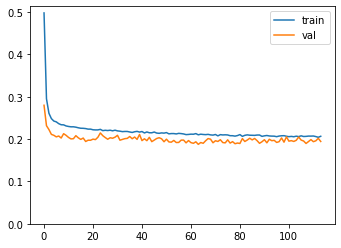

In [17]:
DECODED_LOSS_WEIGHT = 0.0
REQS_LOSS_WEIGHT = 0.0
EYES_LOSS_WEIGHT = 1.0

mlflow.log_param("decoded loss weight", DECODED_LOSS_WEIGHT)
mlflow.log_param("reqs loss weight", REQS_LOSS_WEIGHT)
mlflow.log_param("eyes loss weight", EYES_LOSS_WEIGHT)

losses = {
    "decoded": "mean_squared_error",
    "outputs": "binary_crossentropy",
    "output_eyes": wing_loss
}

loss_weights = {
    "decoded": DECODED_LOSS_WEIGHT,
    "outputs": REQS_LOSS_WEIGHT,
    "output_eyes": EYES_LOSS_WEIGHT,
}

metrics = {
    "outputs": ["accuracy", precision, recall, f1, fbeta, specificity, npv, mcc],
    "output_eyes": ["mae", "mse", eye_localization_accuracy]
}
METRIC_TO_MONITOR = "val_output_eyes_eye_localization_accuracy"

model.compile(optimizer='adam', loss=losses, loss_weights=loss_weights, metrics=metrics)

FILE_MODEL = FOLDER_MODELS + timestamp_model_name(prefix="multilearner_")
list_callbacks = [
    ModelCheckpoint(FILE_MODEL, monitor=METRIC_TO_MONITOR, mode="max", verbose=1, save_best_only=True), 
    EarlyStopping(monitor=METRIC_TO_MONITOR, mode="max", patience=50, verbose=1, restore_best_weights=True)
]

outputs_train = {
    "decoded": x_train,
    "outputs": y_train_reqs,
    "output_eyes": y_train_eyes,
}

outputs_valid = {
    "decoded": x_val,
    "outputs": y_val_reqs,
    "output_eyes": y_val_eyes,
}

hist = model.fit(
    x=x_train,
    y=outputs_train,
    batch_size=32,
    epochs=500,
    validation_data=(x_val, outputs_valid),
    callbacks=list_callbacks,
)

plot.keras_hist(hist.history)

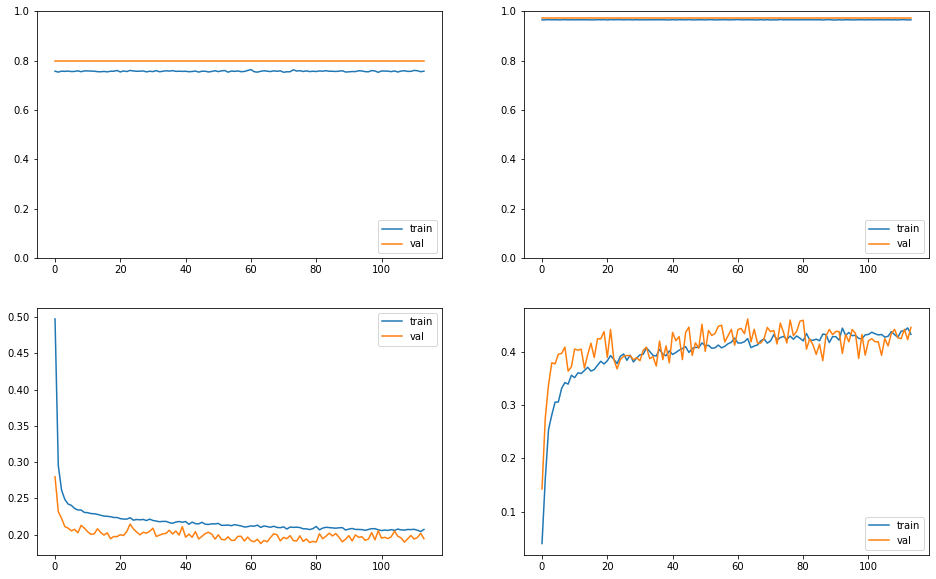

In [18]:
history = hist.history

plt.figure(figsize=(16, 10))
plt.subplot(2, 2, 1)
plt.plot(history['outputs_matthews_correlation_coefficient'], label='train')
plt.plot(history['val_outputs_matthews_correlation_coefficient'], label='val')
plt.ylim(0, 1)
plt.legend(loc='lower right')

plt.subplot(2, 2, 2)
plt.plot(history['outputs_fbeta'], label='train')
plt.plot(history['val_outputs_fbeta'], label='val')
plt.ylim(0, 1)
plt.legend(loc='lower right')

plt.subplot(2, 2, 3)
plt.plot(history['output_eyes_loss'], label='train')
plt.plot(history['val_output_eyes_loss'], label='val')
plt.legend(loc='upper right')

plt.subplot(2, 2, 4)
plt.plot(history['output_eyes_eye_localization_accuracy'], label='train')
plt.plot(history['val_output_eyes_eye_localization_accuracy'], label='val')
plt.legend(loc='lower right')

# Test Model

[1 1 1 0 1 1 1 1 1 0 1 0 1 1 1 1 1 1 1 1 0 0 1]
[[1 1 1 0 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 0 0 1]]
[65.  79.5 95.  79.5]
[66.29743  78.578926 96.38803  78.00605 ]


Text(0.5, 1.0, 'decoded image')

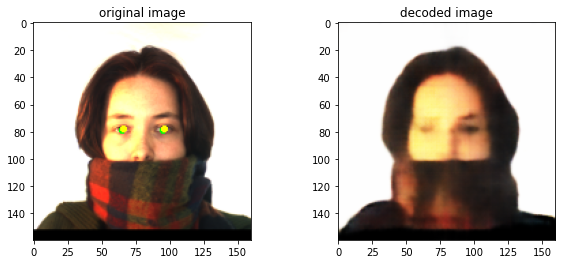

In [45]:
random_idx = np.random.choice(x_val.shape[0])
im = np.expand_dims(x_val[random_idx], axis=0)
y_true_reqs = y_val_reqs[random_idx]
y_true_eyes = y_val_eyes[random_idx] * im.shape[1]

y_pred_decoded, y_pred_reqs, y_pred_eyes = model.predict(im)
y_pred_reqs = np.where(y_pred_reqs > 0.5, 1, 0)
y_pred_eyes = (y_pred_eyes * im.shape[1]).flatten()

print(y_true_reqs, y_pred_reqs, sep='\n')
print(y_true_eyes, y_pred_eyes, sep='\n')

im = (im * 255).squeeze()[:, :, ::-1].astype(np.uint8)
true_r = tuple(y_true_eyes[:2].astype(np.int))
true_l = tuple(y_true_eyes[2:].astype(np.int))
pred_r = tuple(y_pred_eyes[:2].astype(np.int))
pred_l = tuple(y_pred_eyes[2:].astype(np.int))
cv2.circle(im, true_r, radius=1, color=(0, 255, 0), thickness=2)
cv2.circle(im, true_l, radius=1, color=(0, 255, 0), thickness=2)
cv2.circle(im, pred_r, radius=1, color=(255, 255, 0), thickness=2)
cv2.circle(im, pred_l, radius=1, color=(255, 255, 0), thickness=2)

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.imshow(im)
plt.title('original image')

plt.subplot(1, 2, 2)
plt.imshow(y_pred_decoded.squeeze()[:, :, ::-1])
plt.title('decoded image')

# Save Classification Model 

In [46]:
FILE_MODEL_CLF = FILE_MODEL.replace('multilearner', 'model')
print(FILE_MODEL_CLF)

model_clf = Model(
    inputs=model.inputs,
    outputs=[model.get_layer('outputs').output, model.get_layer('output_eyes').output],
    name="ICAOnet"
)
model_clf.summary()

model_clf.save(FILE_MODEL_CLF)

../../models/unsupervised_supervised/model_2022_08_06-11_38_47.h5
Model: "ICAOnet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 160, 160, 3)  0                                            
__________________________________________________________________________________________________
conv_1 (Conv2D)                 (None, 160, 160, 32) 896         input[0][0]                      
__________________________________________________________________________________________________
bn_1 (BatchNormalization)       (None, 160, 160, 32) 128         conv_1[0][0]                     
__________________________________________________________________________________________________
relu_1 (Activation)             (None, 160, 160, 32) 0           bn_1[0][0]                       
__________________________

In [47]:
import cv2
from glob import glob

model_clf = load_model(FILE_MODEL_CLF)

list_files = [PATH_TO_ROOT + 'data/cropped_faces/images/afwDB_0.png']
random_file = np.random.choice(list_files)
print(random_file)

im = load.images_from_list_files([random_file], output_size=IMAGE_SIZE, interpolation=cv2.INTER_AREA)
im /= 255

y_pred_ori = model.predict(im)
y_pred_clf, y_pred_reg = model_clf.predict(im)
assert(np.allclose(y_pred_ori[1], y_pred_clf))
assert(np.allclose(y_pred_ori[2], y_pred_reg))

print("Reqs:")
for y_pred in y_pred_clf[0]:
    print(y_pred)

print("\nEyes:")
for y_pred in y_pred_reg[0]:
    print(y_pred)

../../data/cropped_faces/images/afwDB_0.png


C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\keras\engine\saving.py:341: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '



Reqs:
0.64809215
0.9347415
0.99573874
0.08281669
0.991169
0.9998725
0.9772672
0.27883732
0.96358013
0.053408027
0.20580012
0.14253017
0.9828384
0.47127613
0.8292506
0.99030715
0.7546116
0.97962976
0.89305204
0.65849125
0.9751568
0.82795393
0.9905076

Eyes:
0.4198063
0.44754112
0.57570523
0.44433606


# Embeddings Visualization 

In [48]:
FOLDER_LOGS = '../../logs/unsupervised_supervised/'

### Metadata 

In [49]:
image_files = np.array(dataset.image_files)[x_val_idx]
data = np.array(dataset.images)[x_val_idx]
mrks = np.array(dataset.mrks)[x_val_idx]

image_files = [basename(filepath) for filepath in image_files]
print(len(image_files))
print(data.shape)

509
(509, 160, 160, 3)


In [50]:
with open(f'{FOLDER_LOGS}/metadata.tsv', 'w') as metadata_file:
    for file in image_files:
        metadata_file.write(file+'\n')

mlflow.log_artifact(f'{FOLDER_LOGS}/metadata.tsv')

### Image Sprite

In [51]:
def images_to_sprite(data):
    """Creates the sprite image along with any necessary padding
    Args:
      data: NxHxW[x3] tensor containing the images.
    Returns:
      data: Properly shaped HxWx3 image with any necessary padding.
    """
    if len(data.shape) == 3:
        data = np.tile(data[...,np.newaxis], (1,1,1,3))
    data = data.astype(np.float32)
    min_data = np.min(data.reshape((data.shape[0], -1)), axis=1)
    data = (data.transpose(1,2,3,0) - min_data).transpose(3,0,1,2)
    max_data = np.max(data.reshape((data.shape[0], -1)), axis=1)
    data = (data.transpose(1,2,3,0) / max_data).transpose(3,0,1,2)

    n = int(np.ceil(np.sqrt(data.shape[0])))
    padding = ((0, n ** 2 - data.shape[0]), (0, 0), (0, 0)) + ((0, 0),) * (data.ndim - 3)
    data = np.pad(data, padding, mode='constant', constant_values=0)
    
    # Tile the individual thumbnails into an image.
    data = data.reshape((n, n) + data.shape[1:]).transpose((0, 2, 1, 3) + tuple(range(4, data.ndim + 1)))
    data = data.reshape((n * data.shape[1], n * data.shape[3]) + data.shape[4:])
    data = (data * 255).astype(np.uint8)
    return data### Embeddings 

In [52]:
im_sprite = images_to_sprite(data)
print(im_sprite.shape)

cv2.imwrite(f'{FOLDER_LOGS}/sprites.png', im_sprite)
mlflow.log_artifact(f'{FOLDER_LOGS}/sprites.png')

(3680, 3680, 3)


### Embeddings 

In [53]:
model = load_model(FILE_MODEL_CLF)

embeddings = GlobalAvgPool2D(name='embeddings')(model.get_layer(name='encoded').output)

model_emb = Model(inputs=model.inputs, outputs=embeddings)
model_emb.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 160, 160, 3)       0         
_________________________________________________________________
conv_1 (Conv2D)              (None, 160, 160, 32)      896       
_________________________________________________________________
bn_1 (BatchNormalization)    (None, 160, 160, 32)      128       
_________________________________________________________________
relu_1 (Activation)          (None, 160, 160, 32)      0         
_________________________________________________________________
pool_1 (MaxPooling2D)        (None, 80, 80, 32)        0         
_________________________________________________________________
conv_2 (Conv2D)              (None, 80, 80, 64)        18496     
_________________________________________________________________
bn_2 (BatchNormalization)    (None, 80, 80, 64)        256 

In [54]:
emb_vectors = model_emb.predict(data)
print(emb_vectors.shape)

(509, 256)


### Tensorboard 

In [55]:
sess = tf.InteractiveSession()

tf_embeddings = tf.Variable(emb_vectors, name='embeddings')
summary_writer = tf.summary.FileWriter(f'{FOLDER_LOGS}')

config = projector.ProjectorConfig()
embedding = config.embeddings.add()
embedding.tensor_name = tf_embeddings.name
embedding.metadata_path = 'metadata.tsv'
embedding.sprite.image_path = 'sprites.png'
embedding.sprite.single_image_dim.extend(IMAGE_SIZE)

projector.visualize_embeddings(summary_writer, config)

saver = tf.train.Saver([tf_embeddings])
sess.run(tf_embeddings.initializer)
saver.save(sess, f'{FOLDER_LOGS}/embeddings.ckpt')

sess.close()

In [56]:
mlflow.end_run()